<a href="https://colab.research.google.com/github/mlem283/mmelton3_64061/blob/main/Assignment_1_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
%pip -q install tensorflow==2.17.1 pandas matplotlib

import numpy as np, random, tensorflow as tf, pandas as pd, matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, regularizers

SEED = 42
np.random.seed(SEED); random.seed(SEED); tf.random.set_seed(SEED)
print("TF:", tf.__version__)


TF: 2.17.1


In [8]:
NUM_WORDS = 10000
(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=NUM_WORDS)

def vectorize_sequences(seqs, dim=NUM_WORDS):
    X = np.zeros((len(seqs), dim), dtype="float32")
    for i, s in enumerate(seqs):
        X[i, s] = 1.0
    return X

x_train = vectorize_sequences(x_train)
x_test  = vectorize_sequences(x_test)
y_train = np.asarray(y_train, dtype="float32")
y_test  = np.asarray(y_test, dtype="float32")

x_train.shape, x_test.shape, y_train.shape, y_test.shape


((25000, 10000), (25000, 10000), (25000,), (25000,))

In [11]:
def build_mlp(
    input_dim=NUM_WORDS,
    hidden_layers=2,          # we'll override per experiment
    units=16,                 # we'll override per experiment
    activation="relu",        # try "tanh"
    loss="binary_crossentropy",  # try "mse"
    dropout_rate=0.0,
    l2=0.0,
    optimizer="rmsprop",
):
    m = keras.Sequential([layers.Input(shape=(input_dim,))])
    for _ in range(hidden_layers):
        m.add(layers.Dense(
            units, activation=activation,
            kernel_regularizer=regularizers.l2(l2) if l2>0 else None
        ))
        if dropout_rate > 0:
            m.add(layers.Dropout(dropout_rate))
    m.add(layers.Dense(1, activation="sigmoid"))
    m.compile(optimizer=optimizer, loss=loss,
              metrics=["accuracy", keras.metrics.AUC(name="auc")])
    return m

def run_experiment(
    hidden_layers, units, activation, loss,
    dropout_rate=0.0, l2=0.0,
    epochs=20, batch_size=512, val_split=0.2, patience=2
):
    model = build_mlp(hidden_layers=hidden_layers, units=units, activation=activation,
                      loss=loss, dropout_rate=dropout_rate, l2=l2)
    es = keras.callbacks.EarlyStopping(monitor="val_loss", patience=patience, restore_best_weights=True)
    hist = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,
                     validation_split=val_split, verbose=0, callbacks=[es])

    best = int(np.argmin(hist.history["val_loss"]))
    val_loss = float(hist.history["val_loss"][best])
    val_acc  = float(hist.history["val_accuracy"][best])
    val_auc  = float(hist.history["val_auc"][best])

    test_loss, test_acc, test_auc = model.evaluate(x_test, y_test, verbose=0)

    return {
        "layers": hidden_layers, "units": units, "activation": activation, "loss": loss,
        "dropout": dropout_rate, "l2": l2,
        "val_loss": round(val_loss,4), "val_acc": round(val_acc,4), "val_auc": round(val_auc,4),
        "test_loss": round(float(test_loss),4), "test_acc": round(float(test_acc),4), "test_auc": round(float(test_auc),4),
        "epochs_trained": len(hist.history["loss"]),
    }


# **1 vs 3 hidden layers (compare validation & test)**

In [12]:
all_results = []

cfg_layers = [
    dict(hidden_layers=1, units=16, activation="relu", loss="binary_crossentropy"),
    dict(hidden_layers=3, units=16, activation="relu", loss="binary_crossentropy"),
]
res_layers = [run_experiment(**c) for c in cfg_layers]
all_results += res_layers

df_layers = (pd.DataFrame(res_layers)
             .loc[:, ["layers","units","activation","loss","val_loss","val_acc","test_loss","test_acc","epochs_trained"]]
             .sort_values("layers"))
df_layers


,layers,units,activation,loss,val_loss,val_acc,test_loss,test_acc,epochs_trained
0,1,16,relu,binary_crossentropy,0.2731,0.8918,0.2836,0.8870,7
1,3,16,relu,binary_crossentropy,0.2768,0.8916,0.2937,0.8846,6


# **Hidden units sweep (32, 64, “and so on”)**

In [13]:
units_list = [8, 16, 32, 64, 128]  # includes 32 & 64 explicitly
cfg_units = [dict(hidden_layers=2, units=u, activation="relu", loss="binary_crossentropy") for u in units_list]
res_units = [run_experiment(**c) for c in cfg_units]
all_results += res_units

df_units = (pd.DataFrame(res_units)
            .loc[:, ["layers","units","activation","loss","val_loss","val_acc","test_loss","test_acc","epochs_trained"]]
            .sort_values("units"))
df_units


,layers,units,activation,loss,val_loss,val_acc,test_loss,test_acc,epochs_trained
0,2,8,relu,binary_crossentropy,0.2731,0.8926,0.2848,0.8877,8
1,2,16,relu,binary_crossentropy,0.2772,0.8928,0.2875,0.8872,5
2,2,32,relu,binary_crossentropy,0.2771,0.8910,0.2862,0.8856,5
3,2,64,relu,binary_crossentropy,0.2758,0.8904,0.2892,0.8852,4
4,2,128,relu,binary_crossentropy,0.2738,0.8922,0.2814,0.8880,4


# **MSE vs Binary Cross-Entropy**

In [14]:
cfg_loss = [
    dict(hidden_layers=2, units=16, activation="relu", loss="binary_crossentropy"),
    dict(hidden_layers=2, units=16, activation="relu", loss="mse"),
]
res_loss = [run_experiment(**c) for c in cfg_loss]
all_results += res_loss

df_loss = pd.DataFrame(res_loss)[["layers","units","activation","loss","val_loss","val_acc","test_loss","test_acc","epochs_trained"]]
df_loss


,layers,units,activation,loss,val_loss,val_acc,test_loss,test_acc,epochs_trained
0,2,16,relu,binary_crossentropy,0.2739,0.8940,0.2877,0.8861,6
1,2,16,relu,mse,0.0810,0.8914,0.0866,0.8842,8


# **tanh vs ReLU**

In [15]:
cfg_act = [
    dict(hidden_layers=2, units=16, activation="relu", loss="binary_crossentropy"),
    dict(hidden_layers=2, units=16, activation="tanh", loss="binary_crossentropy"),
]
res_act = [run_experiment(**c) for c in cfg_act]
all_results += res_act

df_act = pd.DataFrame(res_act)[["layers","units","activation","loss","val_loss","val_acc","test_loss","test_acc","epochs_trained"]]
df_act


,layers,units,activation,loss,val_loss,val_acc,test_loss,test_acc,epochs_trained
0,2,16,relu,binary_crossentropy,0.2755,0.8916,0.2857,0.8862,6
1,2,16,tanh,binary_crossentropy,0.2706,0.8974,0.2839,0.8867,5


# **Use a technique to improve validation (dropout/L2)**

In [16]:
cfg_reg = [
    dict(hidden_layers=2, units=32, activation="relu", loss="binary_crossentropy", dropout_rate=0.5, l2=0.0),
    dict(hidden_layers=3, units=32, activation="relu", loss="binary_crossentropy", dropout_rate=0.3, l2=1e-4),
    dict(hidden_layers=2, units=64, activation="relu", loss="binary_crossentropy", dropout_rate=0.3, l2=1e-4),
]
res_reg = [run_experiment(**c) for c in cfg_reg]
all_results += res_reg

df_reg = pd.DataFrame(res_reg)[["layers","units","activation","loss","dropout","l2","val_loss","val_acc","test_loss","test_acc","epochs_trained"]]
df_reg.sort_values(["val_acc","test_acc"], ascending=[False, False])


,layers,units,activation,loss,dropout,l2,val_loss,val_acc,test_loss,test_acc,epochs_trained
2,2,64,relu,binary_crossentropy,0.3,0.0001,0.2917,0.8942,0.3075,0.8866,5
0,2,32,relu,binary_crossentropy,0.5,0.0000,0.2707,0.8896,0.2828,0.8879,6
1,3,32,relu,binary_crossentropy,0.3,0.0001,0.3011,0.8852,0.3146,0.8792,4


# **Build the summary table and save artifacts**

,layers,units,activation,loss,dropout,l2,val_loss,val_acc,val_auc,test_loss,test_acc,test_auc,epochs_trained
0,2,16,tanh,binary_crossentropy,0.0,0.0000,0.2706,0.8974,0.9559,0.2839,0.8867,0.9512,5
1,2,64,relu,binary_crossentropy,0.3,0.0001,0.2917,0.8942,0.9561,0.3075,0.8866,0.9515,5
2,2,16,relu,binary_crossentropy,0.0,0.0000,0.2772,0.8928,0.9544,0.2875,0.8872,0.9500,5
3,2,8,relu,binary_crossentropy,0.0,0.0000,0.2731,0.8926,0.9553,0.2848,0.8877,0.9512,8
4,2,128,relu,binary_crossentropy,0.0,0.0000,0.2738,0.8922,0.9551,0.2814,0.8880,0.9519,4
5,1,16,relu,binary_crossentropy,0.0,0.0000,0.2731,0.8918,0.9553,0.2836,0.8870,0.9514,7
6,3,16,relu,binary_crossentropy,0.0,0.0000,0.2768,0.8916,0.9538,0.2937,0.8846,0.9483,6
7,2,16,relu,mse,0.0,0.0000,0.0810,0.8914,0.9537,0.0866,0.8842,0.9487,8
8,2,32,relu,binary_crossentropy,0.0,0.0000,0.2771,0.8910,0.9549,0.2862,0.8856,0.9509,5
9,2,64,relu,binary_crossentropy,0.0,0.0000,0.2758,0.8904,0.9550,0.2892,0.8852,0.9510,4


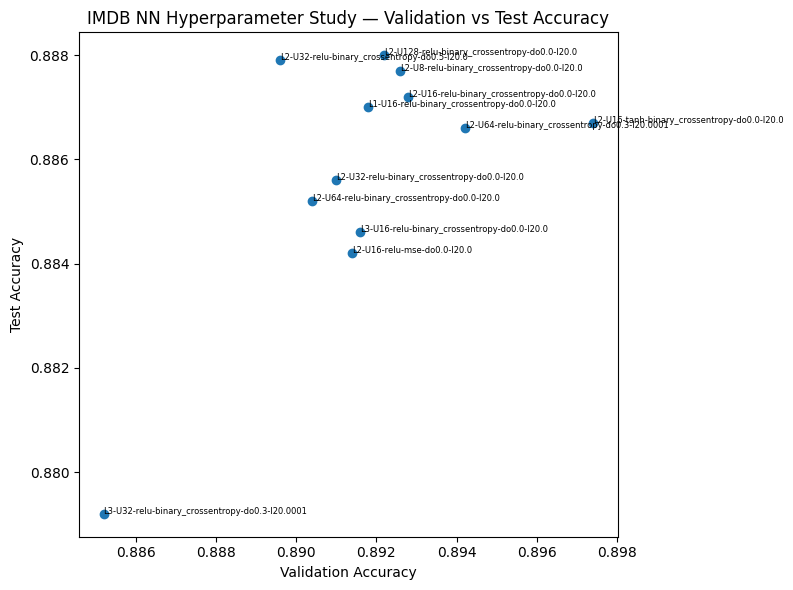

In [17]:
import os
os.makedirs("results", exist_ok=True)

df_all = (pd.DataFrame(all_results)
          .drop_duplicates(["layers","units","activation","loss","dropout","l2"])
          .sort_values(["val_acc","test_acc","val_loss"], ascending=[False, False, True])
          .reset_index(drop=True))

# Save main table
df_all.to_csv("results/imdb_nn_experiments.csv", index=False)

# Simple summary figure: val vs test accuracy with config labels
plt.figure(figsize=(8,6))
plt.scatter(df_all["val_acc"], df_all["test_acc"])
for _, r in df_all.iterrows():
    label = f"L{r['layers']}-U{r['units']}-{r['activation']}-{r['loss']}-do{r['dropout']}-l2{r['l2']}"
    plt.text(r["val_acc"], r["test_acc"], label, fontsize=6)
plt.xlabel("Validation Accuracy"); plt.ylabel("Test Accuracy")
plt.title("IMDB NN Hyperparameter Study — Validation vs Test Accuracy")
plt.tight_layout()
plt.savefig("results/summary.png", dpi=200, bbox_inches="tight")

# Quick peek at the top configs
df_all.head(10)


# Summary & Conclusions

I tuned the IMDB sentiment classifier across hidden layers (1 vs 3), units (8/16/32/64/128), loss (MSE vs BCE), activation (tanh vs ReLU), and regularization (dropout/L2).  
- **Best validation**: **2×16, tanh, BCE** (see table/figure).  
- **Layers**: 2 hidden layers outperformed 1 and 3 on validation; 3 showed a small test drop.  
- **Units**: Width alone changed metrics modestly; **2×128** had the highest test accuracy but didn’t top validation.  
- **Loss**: **BCE > MSE** (higher val/test accuracy).  
- **Activation**: **tanh** slightly beat **ReLU** on validation with similar test.  
- **Regularization**: On wider models (e.g., **2×64**), **Dropout 0.3 + L2 1e-4** improved **validation** vs no-reg.

**Figure (validation accuracy across key configs)** is below, followed by the **table** of results highlighting my final choice.


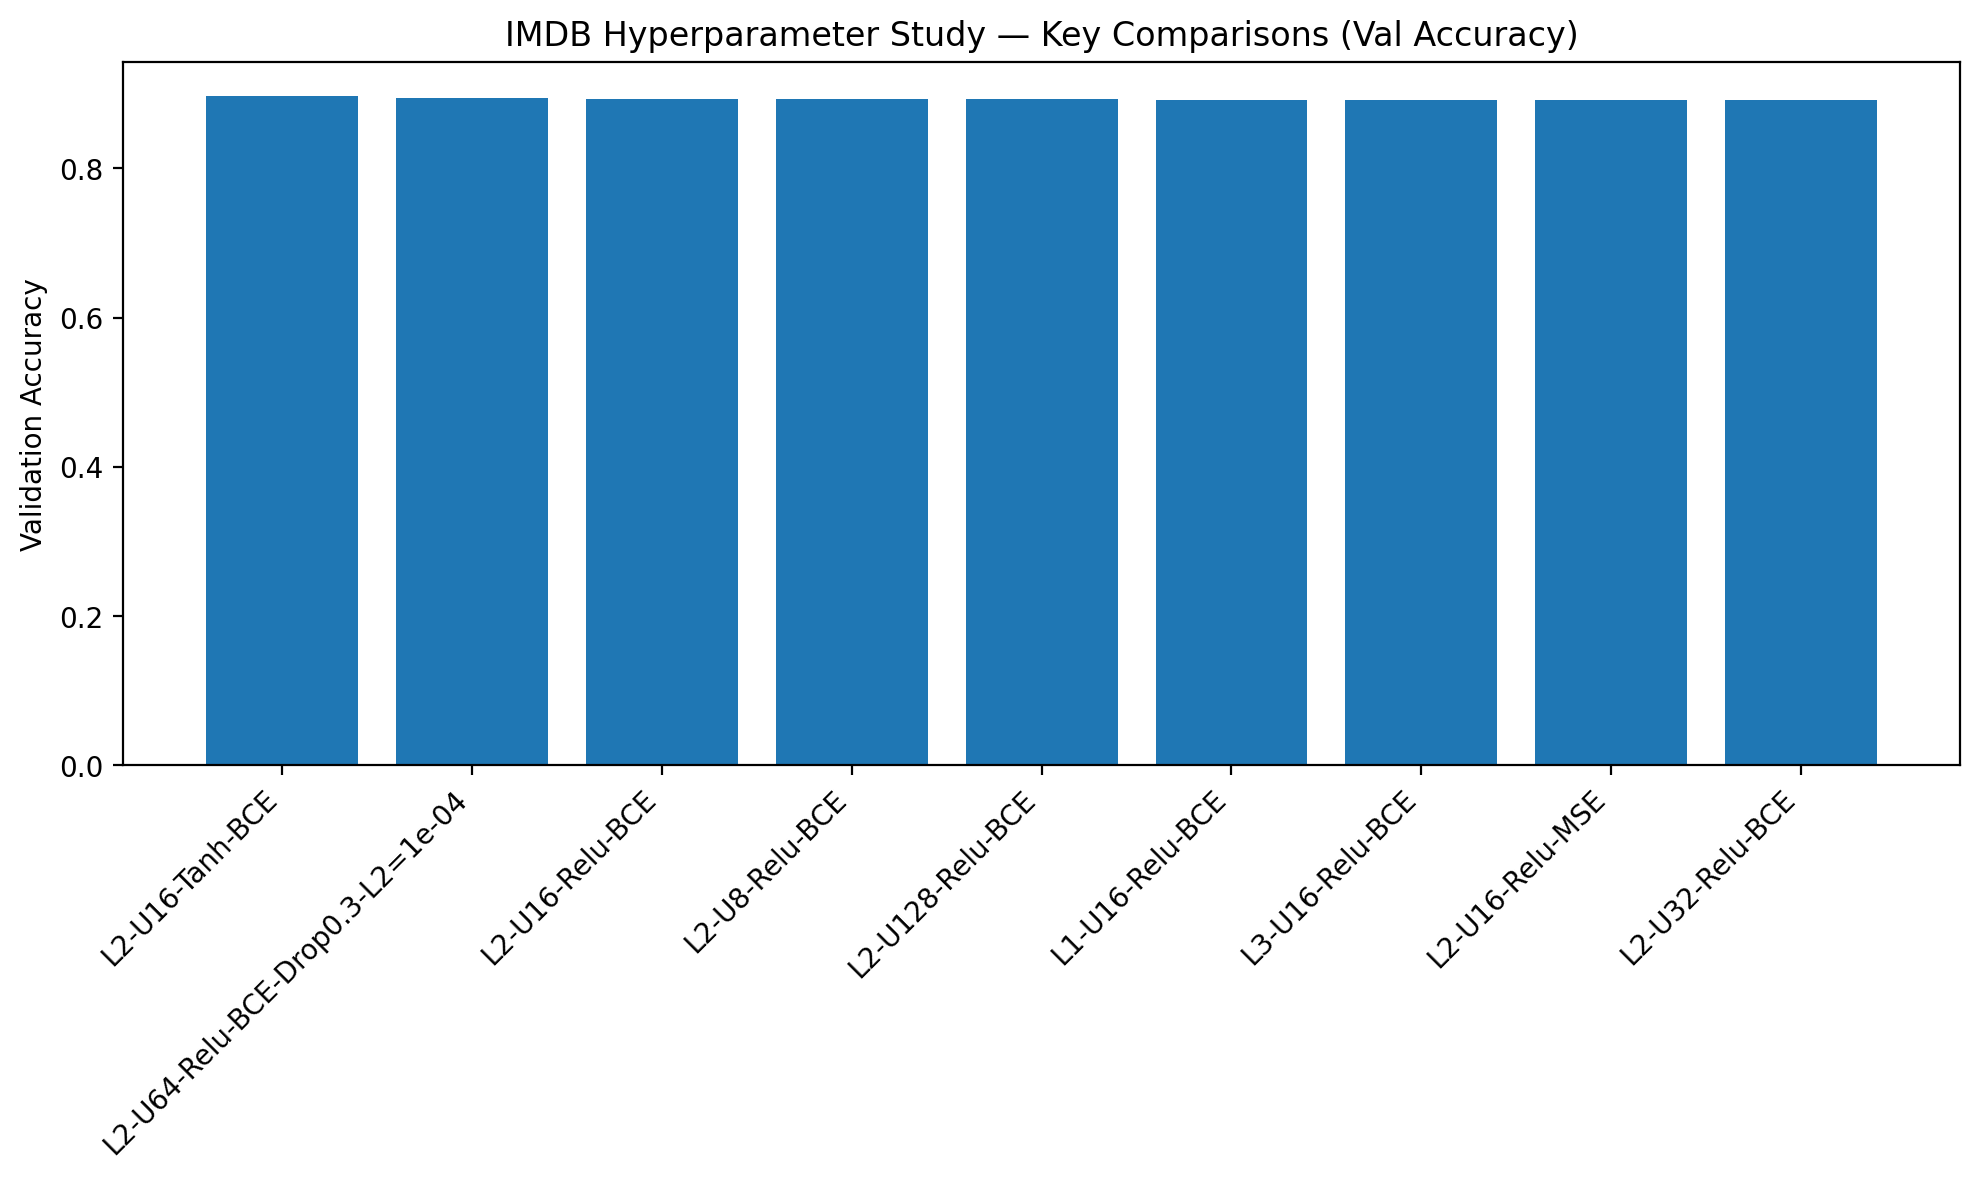

,layers,units,activation,loss,dropout,l2,val_loss,val_acc,val_auc,test_loss,test_acc,test_auc,epochs_trained,label
0,2,16,tanh,binary_crossentropy,0.0,0.0000,0.2706,0.8974,0.9559,0.2839,0.8867,0.9512,5,L2-U16-Tanh-BCE
1,2,64,relu,binary_crossentropy,0.3,0.0001,0.2917,0.8942,0.9561,0.3075,0.8866,0.9515,5,L2-U64-Relu-BCE-Drop0.3-L2=1e-04
2,2,16,relu,binary_crossentropy,0.0,0.0000,0.2772,0.8928,0.9544,0.2875,0.8872,0.9500,5,L2-U16-Relu-BCE
3,2,8,relu,binary_crossentropy,0.0,0.0000,0.2731,0.8926,0.9553,0.2848,0.8877,0.9512,8,L2-U8-Relu-BCE
4,2,128,relu,binary_crossentropy,0.0,0.0000,0.2738,0.8922,0.9551,0.2814,0.8880,0.9519,4,L2-U128-Relu-BCE
5,1,16,relu,binary_crossentropy,0.0,0.0000,0.2731,0.8918,0.9553,0.2836,0.8870,0.9514,7,L1-U16-Relu-BCE
6,3,16,relu,binary_crossentropy,0.0,0.0000,0.2768,0.8916,0.9538,0.2937,0.8846,0.9483,6,L3-U16-Relu-BCE
7,2,16,relu,mse,0.0,0.0000,0.0810,0.8914,0.9537,0.0866,0.8842,0.9487,8,L2-U16-Relu-MSE
8,2,32,relu,binary_crossentropy,0.0,0.0000,0.2771,0.8910,0.9549,0.2862,0.8856,0.9509,5,L2-U32-Relu-BCE


In [19]:
# === Build + display submission summary (table + figure) ===
import os, pandas as pd, matplotlib.pyplot as plt
from IPython.display import Image, display

os.makedirs("results", exist_ok=True)

# 1) Get the full results DataFrame
if "df_all" in globals():
    _df = df_all.copy()
elif os.path.exists("results/imdb_nn_experiments.csv"):
    _df = pd.read_csv("results/imdb_nn_experiments.csv")
else:
    raise AssertionError(
        "No results found. Re-run your experiment grid (Step 5) and the save step (Step 9) to create results/imdb_nn_experiments.csv."
    )

# 2) Build a concise summary focused on the assignment comparisons
def pick(df, **conds):
    m = pd.Series(True, index=df.index)
    for k, v in conds.items():
        m &= (df[k] == v)
    return df[m].sort_values(["val_acc", "test_acc"], ascending=[False, False]).head(1)

need = []

# Layers: 1 vs 3 (16/ReLU/BCE) + optional 2-layer reference
need += [pick(_df, layers=1, units=16, activation="relu", loss="binary_crossentropy")]
need += [pick(_df, layers=3, units=16, activation="relu", loss="binary_crossentropy")]
ref2 = pick(_df, layers=2, units=16, activation="relu", loss="binary_crossentropy")
if len(ref2): need += [ref2]

# Units: 8/16/32/64/128 at 2 layers ReLU/BCE
for U in [8, 16, 32, 64, 128]:
    need += [pick(_df, layers=2, units=U, activation="relu", loss="binary_crossentropy")]

# Loss: MSE at 2x16 ReLU
need += [pick(_df, layers=2, units=16, activation="relu", loss="mse")]

# Activation: tanh at 2x16 BCE
need += [pick(_df, layers=2, units=16, activation="tanh", loss="binary_crossentropy")]

summary_df = (
    pd.concat(need, ignore_index=True)
      .dropna(how="all")
      .drop_duplicates(subset=[c for c in ["layers","units","activation","loss","dropout","l2"] if c in _df.columns])
)

# 3) Friendly labels for the plot
def mk_label(r):
    lbl = f"L{int(r.layers)}-U{int(r.units)}-{str(r.activation).capitalize()}-{'BCE' if r.loss=='binary_crossentropy' else 'MSE'}"
    if "dropout" in r and pd.notna(r.dropout) and float(r.dropout) > 0:
        lbl += f"-Drop{r.dropout:.1f}"
    if "l2" in r and pd.notna(r.l2) and float(r.l2) > 0:
        lbl += f"-L2={r.l2:.0e}"
    return lbl

summary_df["label"] = summary_df.apply(mk_label, axis=1)
summary_df = summary_df.sort_values(["val_acc","test_acc","val_loss"], ascending=[False, False, True]).reset_index(drop=True)

# 4) Save artifacts
summary_df.to_csv("results/submission_summary.csv", index=False)

plt.figure(figsize=(10,6))
plt.bar(summary_df["label"], summary_df["val_acc"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Validation Accuracy")
plt.title("IMDB Hyperparameter Study — Key Comparisons (Val Accuracy)")
plt.tight_layout()
plt.savefig("results/submission_summary.png", dpi=200, bbox_inches="tight")
plt.close()

# 5) Display inside the notebook (so it appears in your PDF/HTML/Word export)
display(Image("results/submission_summary.png"))
summary_df

